In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo

First, let's implement a delay synapse so we don't have to worry about using nengolib

In [20]:
class Delay(nengo.synapses.Synapse):
    def __init__(self, delay, size_in=1):
        self.delay = delay
        super().__init__(default_size_in=size_in, default_size_out=size_in)

    def make_state(self, shape_in, shape_out, dt, dtype=None, y0=None):
        return {}

    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        steps = int(self.delay/dt)
        if steps == 0:
            def step_delay(t, x):
                return x
            return step_delay
        assert steps > 0

        state = np.zeros((steps, shape_in[0]))
        state_index = np.array([0])

        def step_delay(t, x, state=state, state_index=state_index):
            result = state[state_index]
            state[state_index] = x
            state_index[:] = (state_index + 1) % state.shape[0]
            return result

        return step_delay

Now let's do normal PES rule, where `c` is the context that we're using to predict from, `z` is the value we want to predict, and `z_pred` is our prediction.  `t_delay` says how far into the future we're going to predict it.

Note that `t_delay` appears in two places.  First, it appears in our error calculation, in that the prediction is delayed before subtracting from the observation.  Second, it appears in the PES rule's `pre_synapse` parameter, which is applied to the activity of the neurons before multiplying them by the error in the PES rule.

In [21]:
freq = 5
learning_rate = 5e-5
t_delay = 0.05

model = nengo.Network()
with model:
    model.config[nengo.Connection].synapse = None
    
    def stim_func(t):
        return np.sin(t*2*np.pi*freq), np.cos(t*2*np.pi*freq)
    c = nengo.Node(stim_func)

    z = nengo.Node(None, size_in=1)
    nengo.Connection(c[0], z)
    
    
    z_pred = nengo.Node(None, size_in=1)
    
    ens = nengo.Ensemble(n_neurons=1000, dimensions=c.size_out, 
                         neuron_type=nengo.LIFRate())
    nengo.Connection(c, ens)

    conn = nengo.Connection(ens.neurons, z_pred, 
            transform=np.zeros((z_pred.size_in, ens.n_neurons)),
            learning_rule_type=nengo.PES(learning_rate=learning_rate,
                                         pre_synapse=Delay(t_delay)))
                            
    error = nengo.Node(None, size_in=1)
    nengo.Connection(z_pred, error, synapse=Delay(t_delay))
    nengo.Connection(z, error, transform=-1)
    nengo.Connection(error, conn.learning_rule)
        
    p_input = nengo.Probe(c)
    p_prediction = nengo.Probe(z_pred)
    p_target = nengo.Probe(z)
    
sim = nengo.Simulator(model)
sim.run(20)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

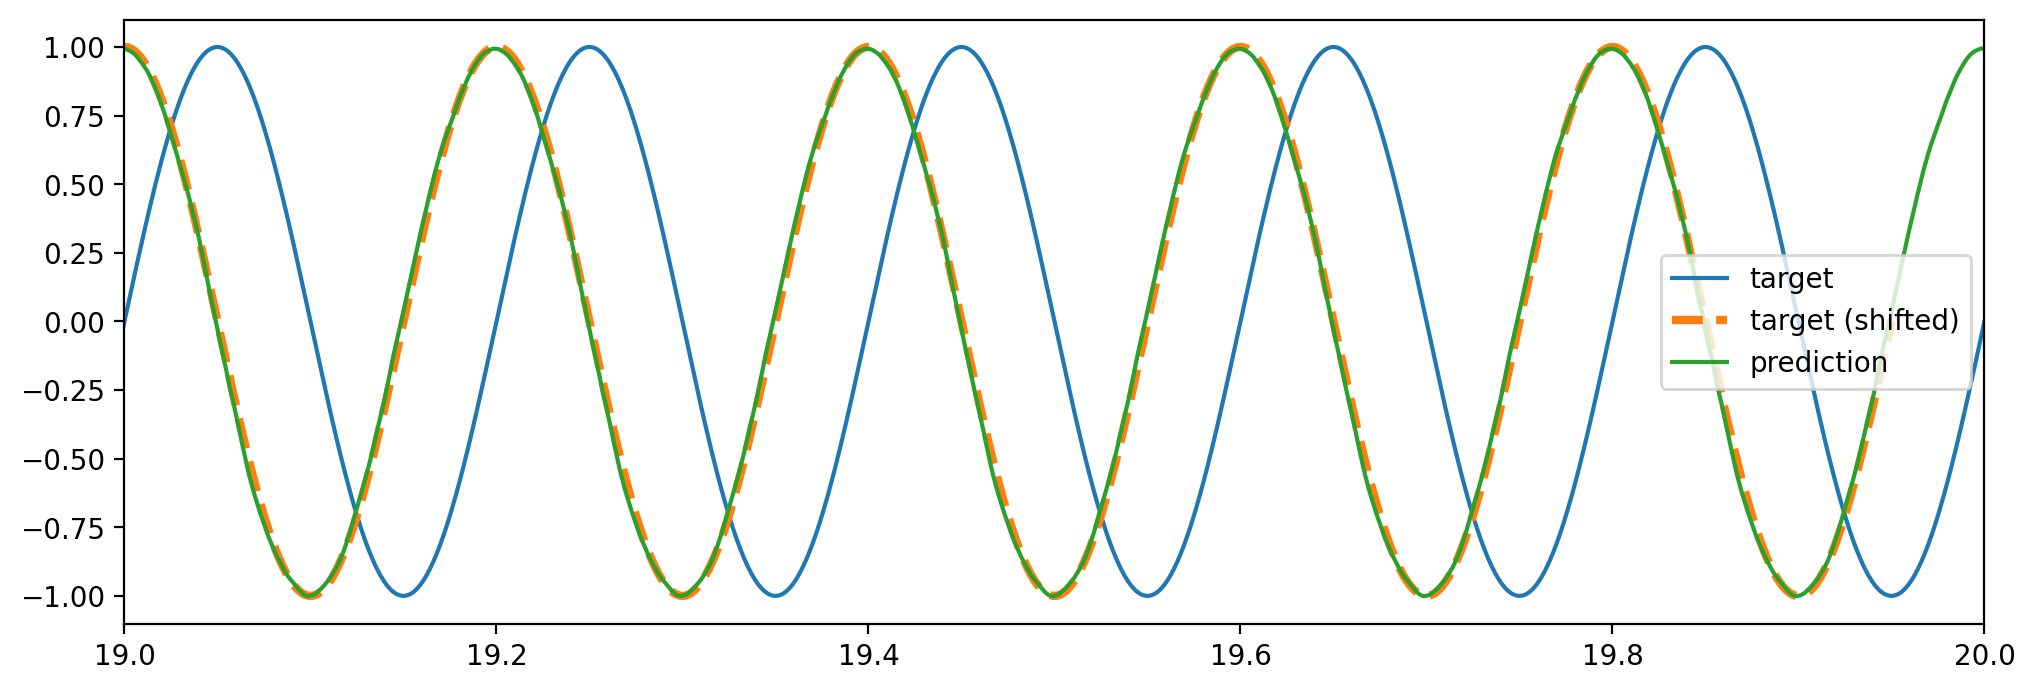

In [22]:
plt.figure(figsize=(12,4), dpi=200)
plt.plot(sim.trange(), sim.data[p_target], label='target')
plt.plot(sim.trange()-t_delay, sim.data[p_target], ls='--', label='target (shifted)', lw=3)
plt.plot(sim.trange(), sim.data[p_prediction], label='prediction')
plt.legend()
plt.xlim(19,20)
plt.show()